In [ ]:
# Cell 1: Install and Import Required Libraries
!pip install tensorflow opencv-python matplotlib scikit-image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import os
from google.colab import files
from PIL import Image
import io

print("TensorFlow Version:", tf.__version__)



TensorFlow Version: 2.18.0


In [31]:
from google.colab import drive
import os

drive.mount('/content/drive')

project_path = "/content/drive/MyDrive/handwriting_project"
os.makedirs(project_path, exist_ok=True)


Mounted at /content/drive


In [37]:
from tensorflow.keras.models import load_model
import numpy as np
import json
import os

# Define your project path
project_path = "/content/drive/MyDrive/handwriting_project"

# Load model
model_path = f"{project_path}/fine_tuned_model.h5"
if os.path.exists(model_path):
    model = load_model(model_path)
    print("✅ Model loaded successfully")
else:
    print("❌ Model file not found")

# Load character mapping
mapping_path = f"{project_path}/char_mapping.json"
if os.path.exists(mapping_path):
    with open(mapping_path, "r") as f:
        char_mapping = json.load(f)
    print("✅ Character mapping loaded")
else:
    print("⚠️ char_mapping.json not found")

# Load training history (optional)
history_path = f"{project_path}/training_history.npy"
if os.path.exists(history_path):
    history = np.load(history_path, allow_pickle=True).item()
    print("✅ Training history loaded")
else:
    history = None
    print("ℹ️ Training history not found or skipped")


✅ Model loaded successfully
✅ Character mapping loaded
✅ Training history loaded


In [ ]:
# Cell 2: Download and Load EMNIST Dataset
# Download EMNIST dataset
!wget -q https://biometrics.nist.gov/cs_links/EMNIST/matlab.zip
!unzip -q matlab.zip

# Load EMNIST data
import scipy.io

def load_emnist_data():
    """Load EMNIST ByClass dataset"""
    mat_data = scipy.io.loadmat('matlab/emnist-byclass.mat')

    # Extract training and test data
    X_train = mat_data['dataset'][0][0][0][0][0][0]
    y_train = mat_data['dataset'][0][0][0][0][0][1]
    X_test = mat_data['dataset'][0][0][1][0][0][0]
    y_test = mat_data['dataset'][0][0][1][0][0][1]

    # Reshape images (28x28)
    X_train = X_train.reshape(-1, 28, 28, 1)
    X_test = X_test.reshape(-1, 28, 28, 1)

    # Rotate and flip images (EMNIST format correction)
    X_train = np.rot90(X_train, k=-1, axes=(1, 2))
    X_train = np.fliplr(X_train)
    X_test = np.rot90(X_test, k=-1, axes=(1, 2))
    X_test = np.fliplr(X_test)

    return X_train, y_train.flatten(), X_test, y_test.flatten()

# Load data
X_train, y_train, X_test, y_test = load_emnist_data()

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")

# Show class distribution
unique, counts = np.unique(y_train, return_counts=True)
print(f"Class distribution (first 10): {dict(zip(unique[:10], counts[:10]))}")
print(f"Most frequent class has {max(counts)} samples")
print(f"Least frequent class has {min(counts)} samples")

Training data shape: (697932, 28, 28, 1)
Training labels shape: (697932,)
Test data shape: (116323, 28, 28, 1)
Test labels shape: (116323,)
Number of classes: 62
Class distribution (first 10): {np.uint8(0): np.int64(34585), np.uint8(1): np.int64(38374), np.uint8(2): np.int64(34203), np.uint8(3): np.int64(35143), np.uint8(4): np.int64(33535), np.uint8(5): np.int64(31416), np.uint8(6): np.int64(34232), np.uint8(7): np.int64(35754), np.uint8(8): np.int64(33946), np.uint8(9): np.int64(33847)}
Most frequent class has 38374 samples
Least frequent class has 1896 samples


Character mapping: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] ... ['q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


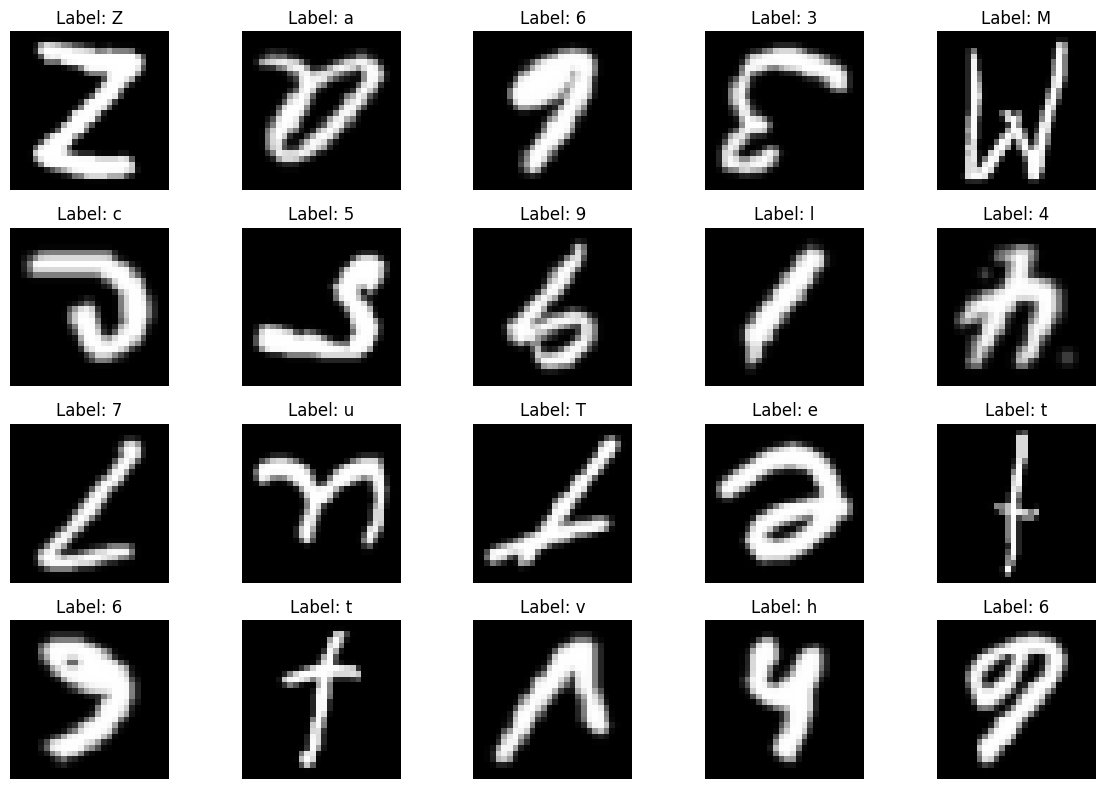

In [ ]:
# Cell 3: Data Preprocessing and Visualization
# Normalize pixel values
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Get class mapping (EMNIST balanced includes digits + letters)
num_classes = len(np.unique(y_train))

# Create character mapping
def get_char_mapping():
    """Create mapping from class labels to characters"""
    chars = []
    # Digits 0-9
    for i in range(10):
        chars.append(str(i))
    # Uppercase letters A-Z
    for i in range(26):
        chars.append(chr(ord('A') + i))
    # Lowercase letters a-z
    for i in range(26):
        chars.append(chr(ord('a') + i))
    return chars

char_mapping = get_char_mapping()
print("Character mapping:", char_mapping[:10], "...", char_mapping[-10:])

# Convert labels to categorical
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Visualize some samples
plt.figure(figsize=(12, 8))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.title(f'Label: {char_mapping[y_train[i]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Cell 4: Build CNN Model Architecture
def create_cnn_model(input_shape, num_classes):
    """Create a CNN model for character recognition"""
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.25),

        # Fully Connected Layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Create and compile model
model = create_cnn_model((28, 28, 1), num_classes)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 62)             │        15,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 552,734 (2.11 MB)

 Trainable params: 550,750 (2.10 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [ ]:
# Cell 5: Train the Model with Class Weights
# Calculate class weights to handle imbalanced data
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print("Sample class weights:")
for i in range(min(10, len(class_weight_dict))):
    char = char_mapping[i]
    weight = class_weight_dict[i]
    print(f"Class {i} ('{char}'): weight = {weight:.3f}")

# Create callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train the model with class weights
history = model.fit(
    X_train, y_train_cat,
    batch_size=128,
    epochs=50,
    validation_data=(X_test, y_test_cat),
    class_weight=class_weight_dict,  # Added class weights
    callbacks=[checkpoint, reduce_lr, early_stopping],
    verbose=1
)


Sample class weights:
Class 0 ('0'): weight = 0.325
Class 1 ('1'): weight = 0.293
Class 2 ('2'): weight = 0.329
Class 3 ('3'): weight = 0.320
Class 4 ('4'): weight = 0.336
Class 5 ('5'): weight = 0.358
Class 6 ('6'): weight = 0.329
Class 7 ('7'): weight = 0.315
Class 8 ('8'): weight = 0.332
Class 9 ('9'): weight = 0.333
Epoch 1/50
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5539 - loss: 1.5557
Epoch 1: val_accuracy improved from -inf to 0.76031, saving model to best_model.h5


5453/5453 ━━━━━━━━━━━━━━━━━━━━ 61s 9ms/step - accuracy: 0.5539 - loss: 1.5556 - val_accuracy: 0.7603 - val_loss: 0.5538 - learning_rate: 0.0010
Epoch 2/50
5451/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7424 - loss: 0.7021
Epoch 2: val_accuracy improved from 0.76031 to 0.76942, saving model to best_model.h5


5453/5453 ━━━━━━━━━━━━━━━━━━━━ 68s 8ms/step - accuracy: 0.7424 - loss: 0.7021 - val_accuracy: 0.7694 - val_loss: 0.5182 - learning_rate: 0.0010
Epoch 3/50
5449/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7623 - loss: 0.6369
Epoch 3: val_accuracy improved from 0.76942 to 0.80892, saving model to best_model.h5


5453/5453 ━━━━━━━━━━━━━━━━━━━━ 80s 8ms/step - accuracy: 0.7623 - loss: 0.6369 - val_accuracy: 0.8089 - val_loss: 0.4956 - learning_rate: 0.0010
Epoch 4/50
5448/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7722 - loss: 0.6133
Epoch 4: val_accuracy did not improve from 0.80892
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.7722 - loss: 0.6133 - val_accuracy: 0.8043 - val_loss: 0.4678 - learning_rate: 0.0010
Epoch 5/50
5448/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7783 - loss: 0.5890
Epoch 5: val_accuracy did not improve from 0.80892
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.7783 - loss: 0.5890 - val_accuracy: 0.8021 - val_loss: 0.4653 - learning_rate: 0.0010
Epoch 6/50
5450/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7813 - loss: 0.5757
Epoch 6: val_accuracy improved from 0.80892 to 0.81956, saving model to best_model.h5


5453/5453 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.7813 - loss: 0.5757 - val_accuracy: 0.8196 - val_loss: 0.4578 - learning_rate: 0.0010
Epoch 7/50
5449/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7874 - loss: 0.5646
Epoch 7: val_accuracy did not improve from 0.81956
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 84s 8ms/step - accuracy: 0.7874 - loss: 0.5646 - val_accuracy: 0.8008 - val_loss: 0.4673 - learning_rate: 0.0010
Epoch 8/50
5450/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7880 - loss: 0.5565
Epoch 8: val_accuracy did not improve from 0.81956
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 80s 8ms/step - accuracy: 0.7880 - loss: 0.5565 - val_accuracy: 0.8061 - val_loss: 0.4414 - learning_rate: 0.0010
Epoch 9/50
5450/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7900 - loss: 0.5494
Epoch 9: val_accuracy did not improve from 0.81956
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.7900 - loss: 0.5494 - val_accuracy: 0.8116 - val_loss: 0.4573 - learning_rate: 0.0010
Epoch 1

5453/5453 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.7944 - loss: 0.5351 - val_accuracy: 0.8300 - val_loss: 0.4312 - learning_rate: 0.0010
Epoch 12/50
5452/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7932 - loss: 0.5364
Epoch 12: val_accuracy did not improve from 0.82996
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.7932 - loss: 0.5364 - val_accuracy: 0.8139 - val_loss: 0.4436 - learning_rate: 0.0010
Epoch 13/50
5452/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7970 - loss: 0.5268
Epoch 13: val_accuracy did not improve from 0.82996
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.7970 - loss: 0.5268 - val_accuracy: 0.8055 - val_loss: 0.4587 - learning_rate: 0.0010
Epoch 14/50
5451/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7967 - loss: 0.5250
Epoch 14: val_accuracy did not improve from 0.82996
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - accuracy: 0.7967 - loss: 0.5250 - val_accuracy: 0.8106 - val_loss: 0.4356 - learning_rate: 0.0010
E

5453/5453 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.7980 - loss: 0.5206 - val_accuracy: 0.8316 - val_loss: 0.4165 - learning_rate: 0.0010
Epoch 16/50
5451/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7973 - loss: 0.5200
Epoch 16: val_accuracy improved from 0.83161 to 0.83387, saving model to best_model.h5


5453/5453 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - accuracy: 0.7973 - loss: 0.5200 - val_accuracy: 0.8339 - val_loss: 0.4152 - learning_rate: 0.0010
Epoch 17/50
5446/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7995 - loss: 0.5185
Epoch 17: val_accuracy did not improve from 0.83387
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.7995 - loss: 0.5185 - val_accuracy: 0.8030 - val_loss: 0.4479 - learning_rate: 0.0010
Epoch 18/50
5446/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8010 - loss: 0.5127
Epoch 18: val_accuracy did not improve from 0.83387
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.8010 - loss: 0.5127 - val_accuracy: 0.8062 - val_loss: 0.4439 - learning_rate: 0.0010
Epoch 19/50
5448/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8010 - loss: 0.5121
Epoch 19: val_accuracy did not improve from 0.83387
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 84s 8ms/step - accuracy: 0.8010 - loss: 0.5121 - val_accuracy: 0.8179 - val_loss: 0.4439 - learning_rate: 0.0010
E

5453/5453 ━━━━━━━━━━━━━━━━━━━━ 80s 8ms/step - accuracy: 0.8025 - loss: 0.5100 - val_accuracy: 0.8345 - val_loss: 0.4161 - learning_rate: 0.0010
Epoch 21/50
5447/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8022 - loss: 0.5114
Epoch 21: val_accuracy did not improve from 0.83450

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.8022 - loss: 0.5114 - val_accuracy: 0.8319 - val_loss: 0.4262 - learning_rate: 0.0010
Epoch 22/50
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8068 - loss: 0.4949
Epoch 22: val_accuracy did not improve from 0.83450
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.8068 - loss: 0.4949 - val_accuracy: 0.8195 - val_loss: 0.4262 - learning_rate: 2.0000e-04
Epoch 23/50
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8087 - loss: 0.4847
Epoch 23: val_accuracy did not improve from 0.83450
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - accuracy: 0.8087

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Save full model (architecture + weights)
model.save('/content/drive/MyDrive/final_model.h5')

# OR just save best weights
!cp best_model.h5 /content/drive/MyDrive/best_model.h5

import json

with open('/content/drive/MyDrive/training_history.json', 'w') as f:
    json.dump(history.history, f)



# Reconnect to Drive
from google.colab import drive
drive.mount('/content/drive')

# Load model or weights
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/final_model.h5')  # or load_weights()

# Load training history
import json
with open('/content/drive/MyDrive/training_history.json', 'r') as f:
    history_dict = json.load(f)

# Use history_dict instead of history.history for plotting

Test Accuracy: 0.8345
Test Loss: 0.4161

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      5778
           1       0.73      0.76      0.74      6330
           2       0.98      0.93      0.95      5869
           3       1.00      0.99      0.99      5969
           4       0.99      0.94      0.96      5619
           5       0.97      0.93      0.95      5190
           6       0.99      0.93      0.96      5705
           7       0.99      0.99      0.99      6139
           8       0.99      0.98      0.98      5633
           9       0.96      0.91      0.93      5686
           A       0.95      0.99      0.97      1062
           B       0.91      0.99      0.95       648
           C       0.85      0.53      0.65      1739
           D       0.78      0.96      0.86       779
           E       0.95      0.99      0.97       851
           F       0.92      0.59      0.72      1440
           G     

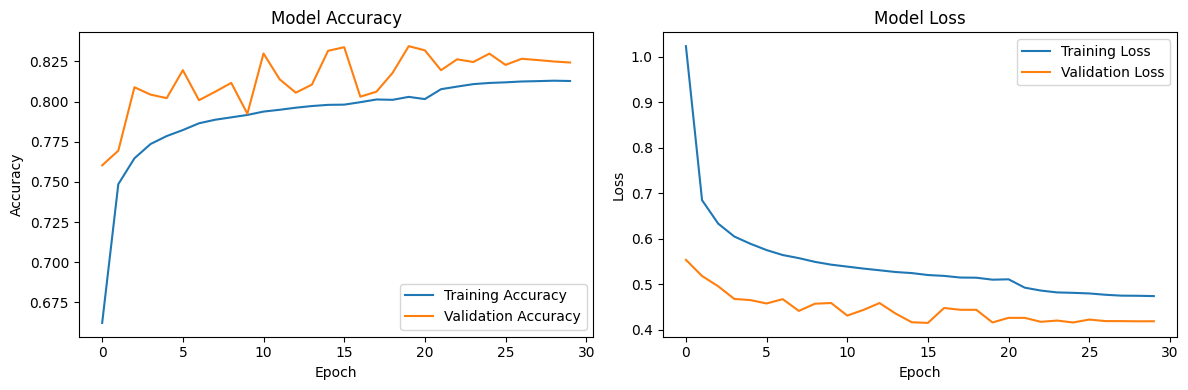

In [ ]:
# Cell 6: Evaluate Model Performance and Class-wise Analysis
# Load best model
model.load_weights('best_model.h5')

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Class-wise accuracy analysis
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report, confusion_matrix

# Print classification report
print("\nClassification Report:")
target_names = [char_mapping[i] for i in range(len(char_mapping))]
print(classification_report(y_test, y_pred_classes, target_names=target_names))

# Show per-class accuracy for some classes
from sklearn.metrics import accuracy_score
print("\nPer-class accuracy (sample):")
for i in range(min(20, len(np.unique(y_test)))):
    mask = y_test == i
    if np.sum(mask) > 0:
        class_acc = accuracy_score(y_test[mask], y_pred_classes[mask])
        print(f"Class {i} ('{char_mapping[i]}'): {class_acc:.3f} ({np.sum(mask)} samples)")

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Cell 7: Image Preprocessing Functions
def preprocess_image(image_path):
    """Preprocess uploaded image for prediction"""
    # Read image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Could not read image")

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)

    # Apply adaptive threshold to get binary image
    binary = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 11, 2
    )

    return binary

def segment_characters(binary_image):
    """Segment individual characters from the image"""
    # Find contours
    contours, _ = cv2.findContours(
        binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    # Filter and sort contours
    character_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 100:  # Filter small contours
            x, y, w, h = cv2.boundingRect(contour)
            # Filter based on aspect ratio and size
            if 0.2 < h/w < 5 and w > 10 and h > 10:
                character_contours.append((x, y, w, h))

    # Sort by x-coordinate (left to right)
    character_contours.sort(key=lambda x: x[0])

    return character_contours

def extract_and_resize_character(image, bbox):
    """Extract character from bounding box and resize to 28x28"""
    x, y, w, h = bbox

    # Extract character region
    char_img = image[y:y+h, x:x+w]

    # Add padding to make it square
    max_dim = max(w, h)
    pad_w = (max_dim - w) // 2
    pad_h = (max_dim - h) // 2

    padded = cv2.copyMakeBorder(
        char_img, pad_h, pad_h, pad_w, pad_w,
        cv2.BORDER_CONSTANT, value=0
    )

    # Resize to 28x28
    resized = cv2.resize(padded, (28, 28), interpolation=cv2.INTER_AREA)

    # Normalize
    normalized = resized.astype('float32') / 255.0

    return normalized

In [28]:
# Cell 8: Character Prediction Function
def predict_characters(image_path):
    """Predict characters from handwritten text image"""
    try:
        # Preprocess image
        binary_img = advanced_preprocess_image(image_path)

        # Segment characters
        char_bboxes = segment_characters(binary_img)

        if not char_bboxes:
            print("No characters detected in the image")
            return ""

        # Extract and predict each character
        predictions = []
        characters = []

        plt.figure(figsize=(15, 5))

        for i, bbox in enumerate(char_bboxes):
            # Extract character
            char_img = improved_character_extractionr(binary_img, bbox)
            characters.append(char_img)

            # Predict
            char_input = char_img.reshape(1, 28, 28, 1)
            prediction = model.predict(char_input, verbose=0)
            predicted_class = np.argmax(prediction)
            confidence = np.max(prediction)

            predicted_char = char_mapping[predicted_class]
            predictions.append((predicted_char, confidence))

            # Visualize
            plt.subplot(2, len(char_bboxes), i + 1)
            plt.imshow(char_img, cmap='gray')
            plt.title(f'{predicted_char}\n({confidence:.2f})')
            plt.axis('off')

            # Show original region
            plt.subplot(2, len(char_bboxes), len(char_bboxes) + i + 1)
            x, y, w, h = bbox
            original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            char_region = original_img[y:y+h, x:x+w]
            plt.imshow(char_region, cmap='gray')
            plt.title('Original')
            plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Combine predictions
        predicted_word = ''.join([pred[0] for pred in predictions])
        avg_confidence = np.mean([pred[1] for pred in predictions])

        print(f"Predicted word: '{predicted_word}'")
        print(f"Average confidence: {avg_confidence:.3f}")

        return predicted_word, predictions

    except Exception as e:
        print(f"Error processing image: {str(e)}")
        return ""


Upload your handwritten image:


Saving WhatsApp Image 2025-06-13 at 19.25.50_38b283d9.jpg to WhatsApp Image 2025-06-13 at 19.25.50_38b283d9.jpg
Processing image: WhatsApp Image 2025-06-13 at 19.25.50_38b283d9.jpg


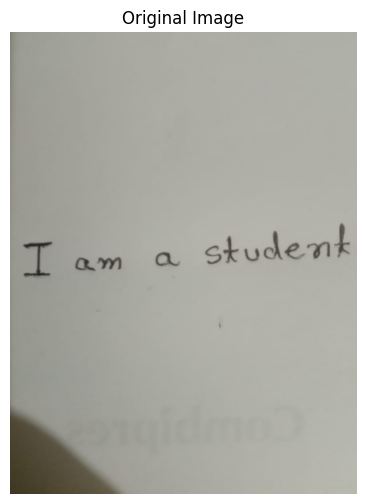


TRYING MULTIPLE ORIENTATIONS AND METHODS

--- Method 1: Enhanced Preprocessing ---


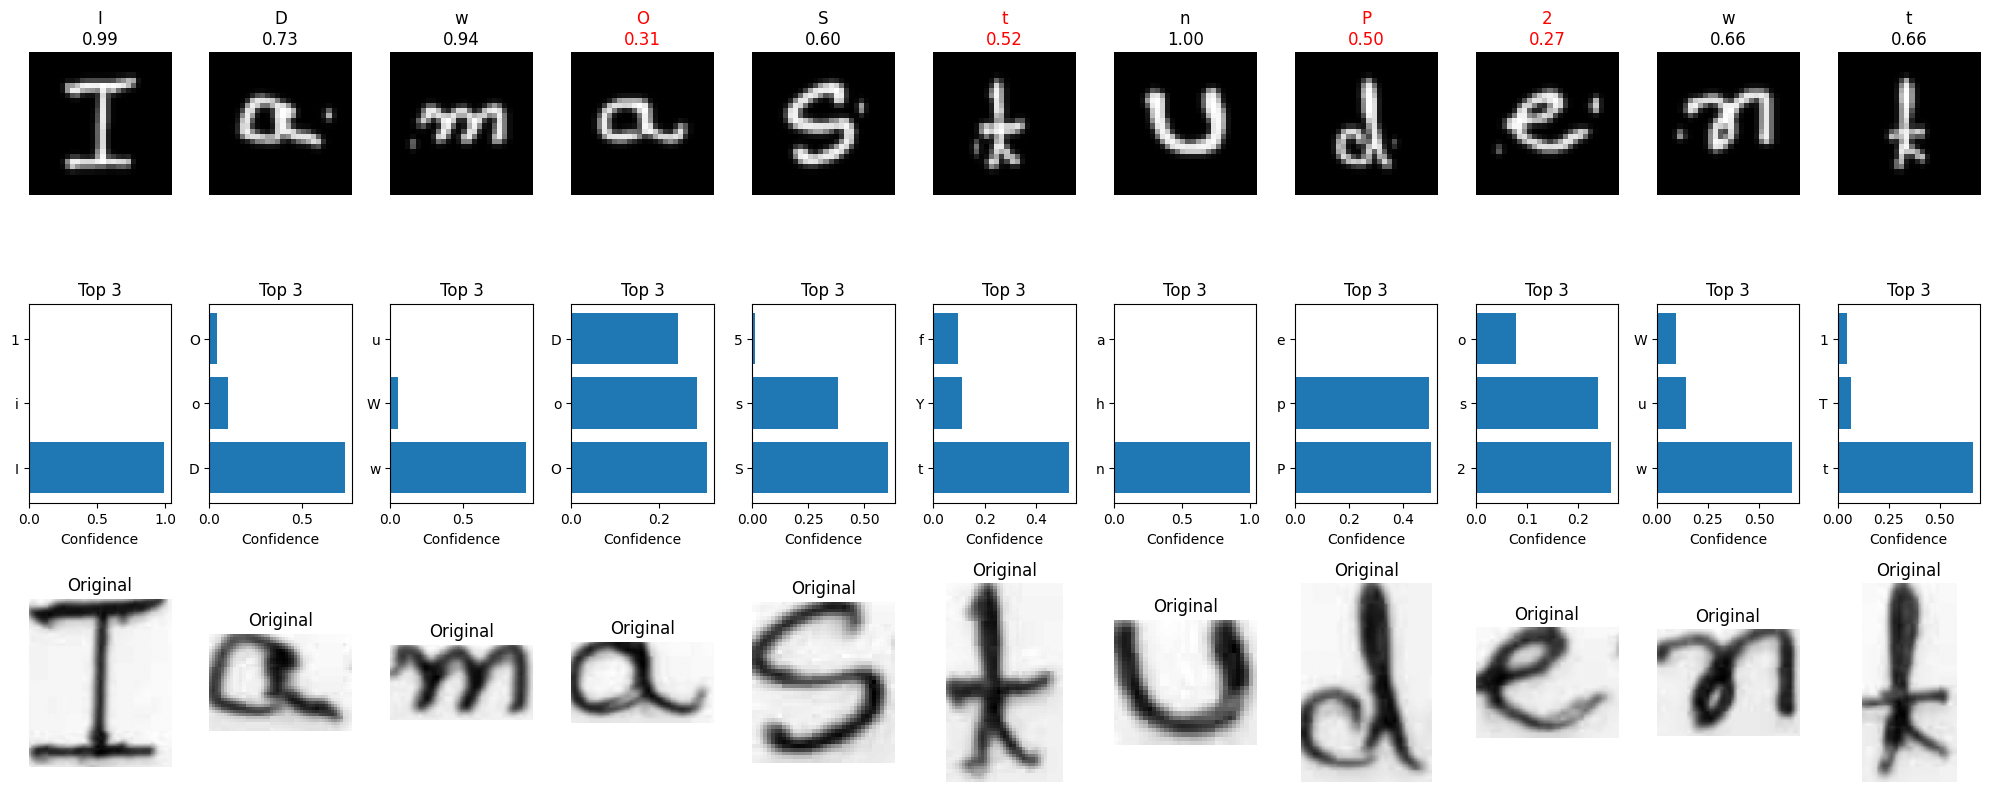

Predicted word: 'IDwOStnP2wt'
Average confidence: 0.654

⚠️  LOW CONFIDENCE CHARACTERS (4):
  Position 3: 'O' (confidence: 0.31)
    Alternatives: o(0.29), D(0.24)
    💡 o/O/0 confusion detected. Check size and thickness.
  Position 5: 't' (confidence: 0.52)
    Alternatives: Y(0.11), f(0.10)
  Position 7: 'P' (confidence: 0.50)
    Alternatives: p(0.50), e(0.00)
  Position 8: '2' (confidence: 0.27)
    Alternatives: s(0.24), o(0.08)
Result 1: 'IDwOStnP2wt'

--- Method 2: Flipped Vertically ---


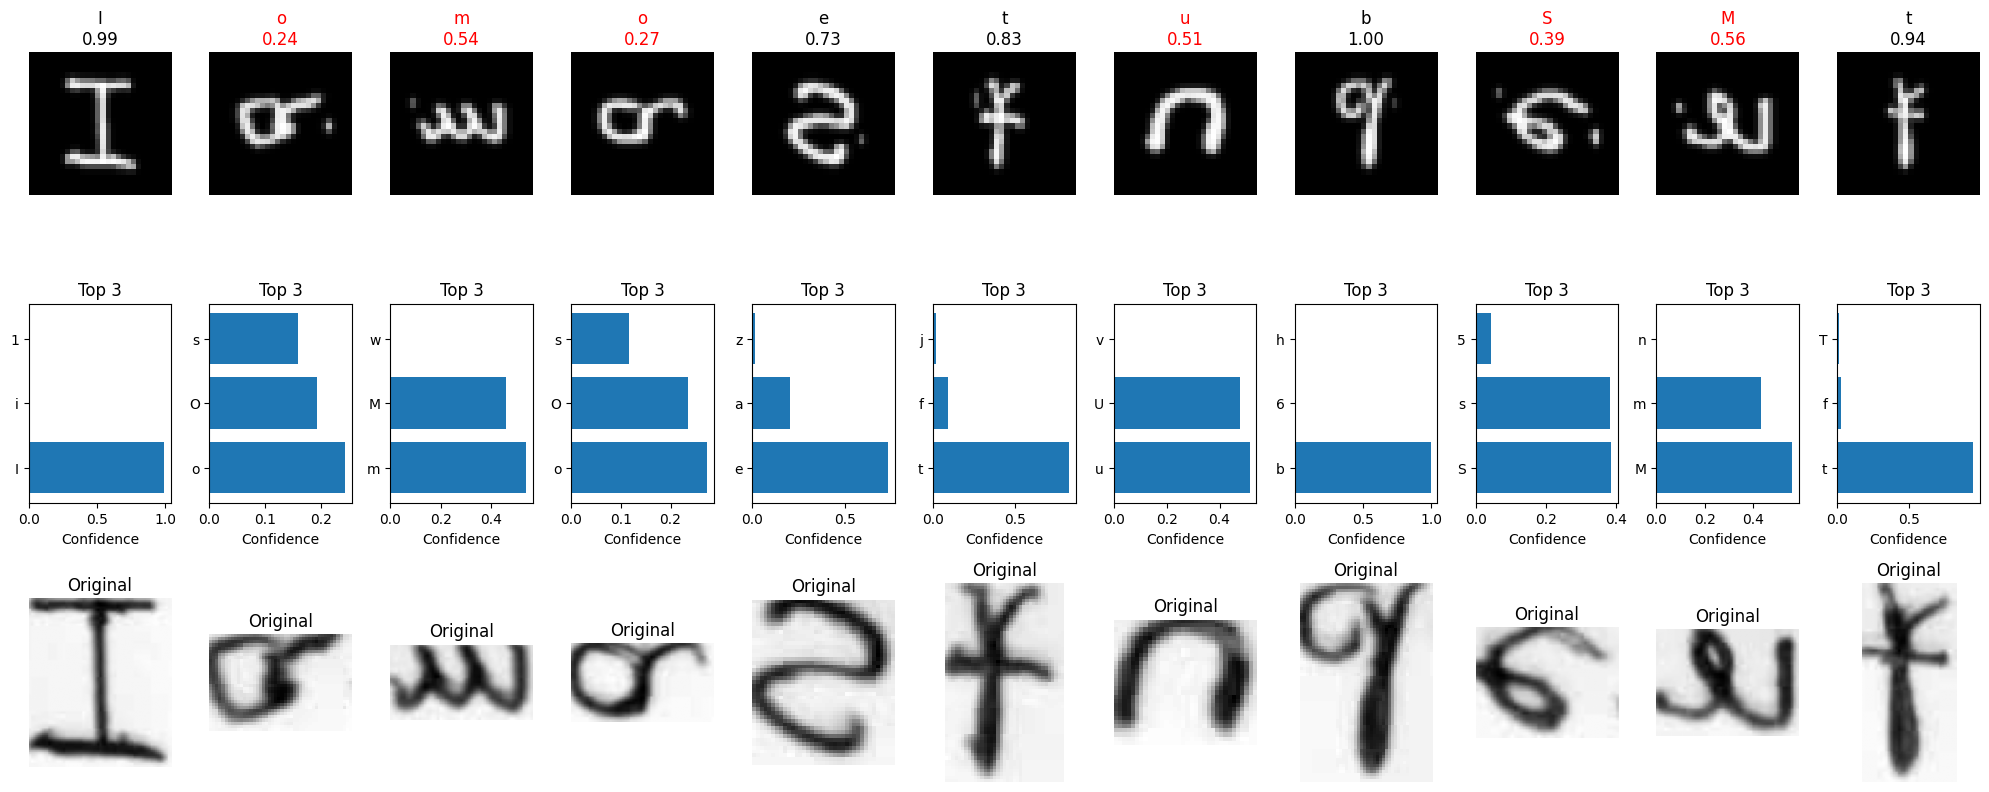

Predicted word: 'IomoetubSMt'
Average confidence: 0.638

⚠️  LOW CONFIDENCE CHARACTERS (6):
  Position 1: 'o' (confidence: 0.24)
    Alternatives: O(0.19), s(0.16)
    💡 o/O/0 confusion detected. Check size and thickness.
  Position 2: 'm' (confidence: 0.54)
    Alternatives: M(0.46), w(0.00)
    💡 M/m/w/W confusion detected. Check letter shape and size.
  Position 3: 'o' (confidence: 0.27)
    Alternatives: O(0.24), s(0.12)
    💡 o/O/0 confusion detected. Check size and thickness.
  Position 6: 'u' (confidence: 0.51)
    Alternatives: U(0.48), v(0.00)
  Position 8: 'S' (confidence: 0.39)
    Alternatives: s(0.38), 5(0.05)
    💡 s/S/5 confusion detected. Check curves and angles.
  Position 9: 'M' (confidence: 0.56)
    Alternatives: m(0.43), n(0.00)
    💡 M/m/w/W confusion detected. Check letter shape and size.
Result 2 (flipped): 'IomoetubSMt'

--- Method 3: Rotated 180° ---


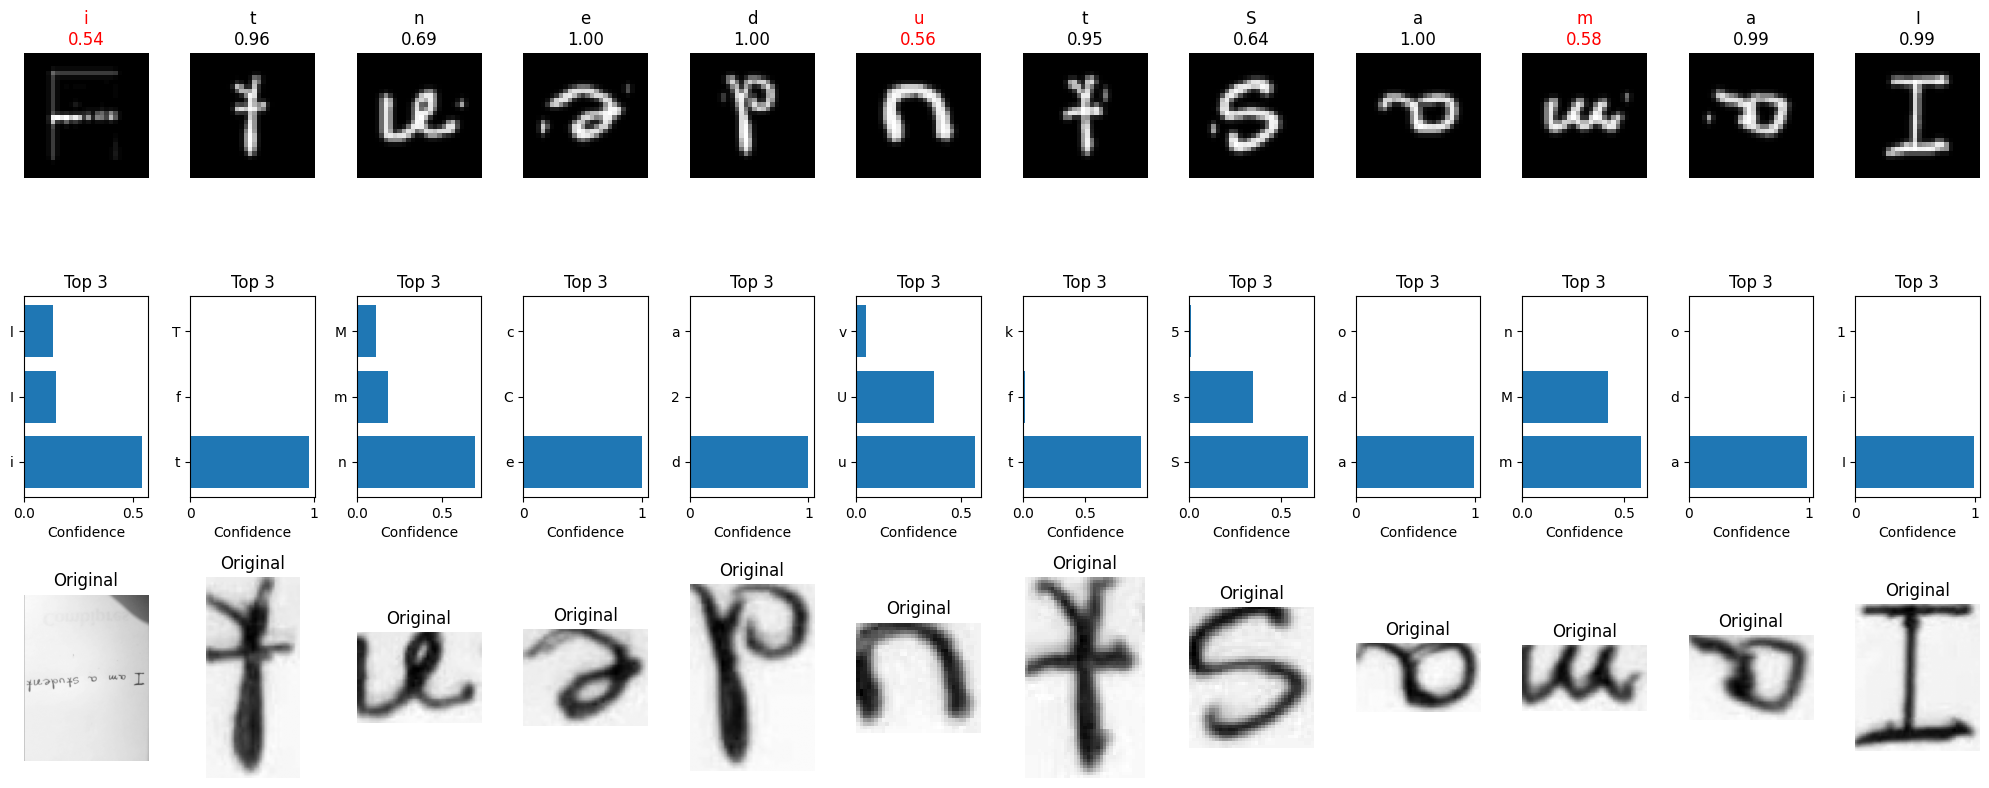

Predicted word: 'itnedutSamaI'
Average confidence: 0.825

⚠️  LOW CONFIDENCE CHARACTERS (3):
  Position 0: 'i' (confidence: 0.54)
    Alternatives: I(0.15), l(0.13)
  Position 5: 'u' (confidence: 0.56)
    Alternatives: U(0.37), v(0.05)
  Position 9: 'm' (confidence: 0.58)
    Alternatives: M(0.42), n(0.00)
    💡 M/m/w/W confusion detected. Check letter shape and size.
Result 3 (rotated): 'itnedutSamaI'

RESULTS COMPARISON
🏆 BEST RESULT: Rotated - 'itnedutSamaI'
   Low confidence characters: 3
Original: 'IDwOStnP2wt' (low conf: 4)
Flipped: 'IomoetubSMt' (low conf: 6)
Rotated: 'itnedutSamaI' (low conf: 3)

--- DETAILED ANALYSIS (Original Image) ---
=== Detailed Analysis ===


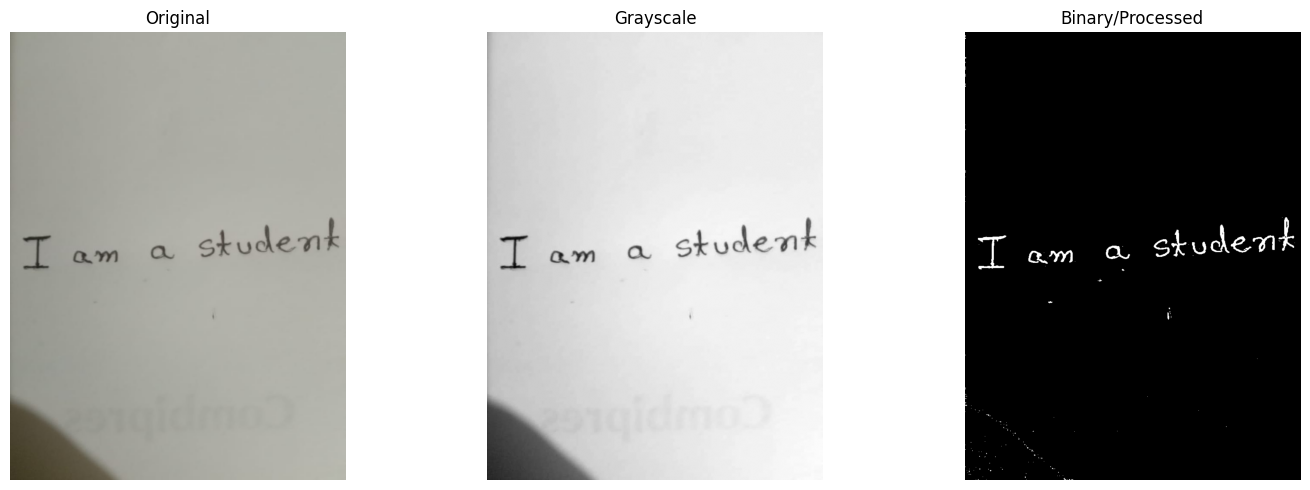

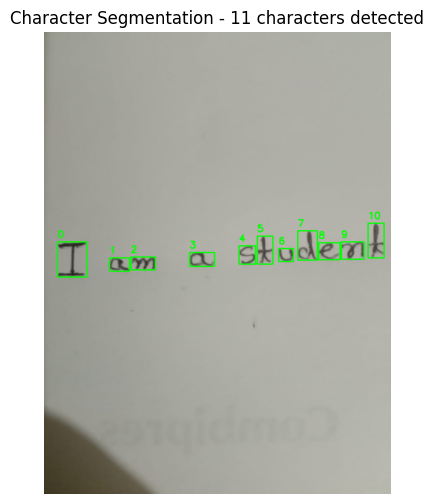

Detected 11 character regions


In [38]:
# Cell 9: Upload and Test Your Handwriting with Enhanced Analysis
print("Upload your handwritten image:")
uploaded = files.upload()

if uploaded:
    # Get the uploaded file name
    image_name = list(uploaded.keys())[0]
    print(f"Processing image: {image_name}")

    # Display the original image
    img = Image.open(io.BytesIO(uploaded[image_name]))
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

    # Try multiple orientations and preprocessing methods
    print("\n" + "="*50)
    print("TRYING MULTIPLE ORIENTATIONS AND METHODS")
    print("="*50)

    # Method 1: Original image with enhanced preprocessing
    print("\n--- Method 1: Enhanced Preprocessing ---")
    try:
        result1 = predict_with_confidence_analysis(image_name, confidence_threshold=0.6)
        if result1:
            word1, preds1, low_conf1 = result1
            print(f"Result 1: '{word1}'")
    except Exception as e:
        print(f"Method 1 failed: {e}")
        result1 = None

    # Method 2: Try with different rotation/flip
    print("\n--- Method 2: Flipped Vertically ---")
    try:
        # Create flipped version
        original_img = cv2.imread(image_name)
        flipped_img = cv2.flip(original_img, 0)  # Flip vertically
        flipped_name = f"flipped_{image_name}"
        cv2.imwrite(flipped_name, flipped_img)

        result2 = predict_with_confidence_analysis(flipped_name, confidence_threshold=0.6)
        if result2:
            word2, preds2, low_conf2 = result2
            print(f"Result 2 (flipped): '{word2}'")
    except Exception as e:
        print(f"Method 2 failed: {e}")
        result2 = None

    # Method 3: Try with 180-degree rotation
    print("\n--- Method 3: Rotated 180° ---")
    try:
        # Create rotated version
        rows, cols = original_img.shape[:2]
        rotation_matrix = cv2.getRotationMatrix2D((cols/2, rows/2), 180, 1)
        rotated_img = cv2.warpAffine(original_img, rotation_matrix, (cols, rows))
        rotated_name = f"rotated_{image_name}"
        cv2.imwrite(rotated_name, rotated_img)

        result3 = predict_with_confidence_analysis(rotated_name, confidence_threshold=0.6)
        if result3:
            word3, preds3, low_conf3 = result3
            print(f"Result 3 (rotated): '{word3}'")
    except Exception as e:
        print(f"Method 3 failed: {e}")
        result3 = None

    # Compare results and suggest best one
    print("\n" + "="*50)
    print("RESULTS COMPARISON")
    print("="*50)

    results = []
    if result1: results.append(("Original", result1[0], result1[2]))
    if result2: results.append(("Flipped", result2[0], result2[2]))
    if result3: results.append(("Rotated", result3[0], result3[2]))

    if results:
        # Find result with highest confidence (least low-confidence characters)
        best_result = min(results, key=lambda x: len(x[2]))
        print(f"🏆 BEST RESULT: {best_result[0]} - '{best_result[1]}'")
        print(f"   Low confidence characters: {len(best_result[2])}")

        for method, word, low_conf in results:
            print(f"{method}: '{word}' (low conf: {len(low_conf)})")
    else:
        print("❌ All methods failed. Try:")
        print("1. Better lighting")
        print("2. Clearer handwriting")
        print("3. Dark pen on white paper")
        print("4. Larger characters")

    # Run detailed analysis on original image
    print("\n--- DETAILED ANALYSIS (Original Image) ---")
    analyze_predictions(image_name)

In [ ]:
# Cell 10: Test with Multiple Images (Optional)
def test_multiple_images():
    """Function to test multiple images"""
    print("Upload multiple images to test:")
    uploaded_files = files.upload()

    results = {}
    for filename in uploaded_files.keys():
        print(f"\n--- Processing {filename} ---")
        try:
            result = predict_characters(filename)
            results[filename] = result
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
            results[filename] = None

    return results

# Uncomment the line below if you want to test multiple images
# test_results = test_multiple_images()

In [ ]:
# Cell 11: Model Improvement Tips and Fine-tuning
print("""
Model Improvement Tips:
1. If accuracy is low, try:
   - Taking clearer photos with good lighting
   - Writing characters larger and more clearly
   - Using dark pen/pencil on white paper
   - Ensuring characters don't touch each other

2. For better segmentation:
   - Leave space between characters
   - Write on lined paper for better alignment
   - Use consistent character size

3. Model fine-tuning options:
   - Collect your own handwriting samples
   - Add data augmentation
   - Adjust threshold parameters
   - Use different preprocessing techniques
""")

# Function to save the model
def save_model_for_deployment():
    """Save the trained model"""
    model.save('handwriting_recognition_model.h5')

    # Save character mapping
    import pickle
    with open('char_mapping.pkl', 'wb') as f:
        pickle.dump(char_mapping, f)

    print("Model and character mapping saved!")

# Uncomment to save the model
save_model_for_deployment()


Model Improvement Tips:
1. If accuracy is low, try:
   - Taking clearer photos with good lighting
   - Writing characters larger and more clearly
   - Using dark pen/pencil on white paper
   - Ensuring characters don't touch each other

2. For better segmentation:
   - Leave space between characters
   - Write on lined paper for better alignment
   - Use consistent character size

3. Model fine-tuning options:
   - Collect your own handwriting samples
   - Add data augmentation
   - Adjust threshold parameters
   - Use different preprocessing techniques

Model and character mapping saved!


In [ ]:
# Cell 12: Performance Analysis and Debugging
def analyze_predictions(image_path):
    """Detailed analysis of predictions with debugging info"""
    print("=== Detailed Analysis ===")

    # Show preprocessing steps
    original = cv2.imread(image_path)
    gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    binary = preprocess_image(image_path)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original')
    axes[0].axis('off')

    axes[1].imshow(gray, cmap='gray')
    axes[1].set_title('Grayscale')
    axes[1].axis('off')

    axes[2].imshow(binary, cmap='gray')
    axes[2].set_title('Binary/Processed')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    # Show segmentation
    char_bboxes = segment_characters(binary)
    img_with_boxes = original.copy()

    for i, (x, y, w, h) in enumerate(char_bboxes):
        cv2.rectangle(img_with_boxes, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(img_with_boxes, str(i), (x, y-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
    plt.title(f'Character Segmentation - {len(char_bboxes)} characters detected')
    plt.axis('off')
    plt.show()

    print(f"Detected {len(char_bboxes)} character regions")

In [ ]:

# Cell 13: Handle Ambiguous Character Recognition
def analyze_confusing_pairs():
    """Analyze performance on commonly confused character pairs"""
    confusing_pairs = [
        ('M', 'm', 'w', 'W'),  # M/m/w/W confusion
        ('s', 'S', '5'),       # s/S/5 confusion
        ('T', 'I', 'l', '1'),  # T/I/l/1 confusion
        ('y', 'g'),            # y/g confusion
        ('o', 'O', '0'),       # o/O/0 confusion
        ('u', 'v'),            # u/v confusion
        ('b', '6'),            # b/6 confusion
        ('q', 'g', 'p'),       # q/g/p confusion
        ('rn', 'm'),           # rn vs m confusion
        ('cl', 'd'),           # cl vs d confusion
    ]

    print("=== CONFUSING CHARACTER PAIRS ANALYSIS ===")

    # Get predictions for test set
    y_pred = model.predict(X_test, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Create reverse mapping
    char_to_idx = {char: idx for idx, char in enumerate(char_mapping)}

    for pair in confusing_pairs:
        print(f"\n--- Analyzing: {' vs '.join(pair)} ---")

        # Get indices for this pair
        pair_indices = []
        for char in pair:
            if char in char_to_idx:
                pair_indices.append(char_to_idx[char])

        if not pair_indices:
            print("Characters not found in dataset")
            continue

        # Analyze confusion between these characters
        for i, true_idx in enumerate(pair_indices):
            true_char = char_mapping[true_idx]
            mask = y_test == true_idx

            if np.sum(mask) > 0:
                predictions_for_class = y_pred_classes[mask]
                correct = np.sum(predictions_for_class == true_idx)
                total = len(predictions_for_class)
                accuracy = correct / total

                print(f"  {true_char}: {accuracy:.3f} accuracy ({correct}/{total})")

                # Show what it gets confused with
                confused_with = {}
                for pred in predictions_for_class:
                    if pred != true_idx and pred in pair_indices:
                        confused_char = char_mapping[pred]
                        confused_with[confused_char] = confused_with.get(confused_char, 0) + 1

                if confused_with:
                    for conf_char, count in confused_with.items():
                        print(f"    → Confused with '{conf_char}': {count} times ({count/total:.1%})")

# Run the analysis
analyze_confusing_pairs()

=== CONFUSING CHARACTER PAIRS ANALYSIS ===

--- Analyzing: M vs m vs w vs W ---
  M: 0.432 accuracy (642/1485)
    → Confused with 'm': 832 times (56.0%)
  m: 0.845 accuracy (392/464)
    → Confused with 'M': 70 times (15.1%)
  w: 0.897 accuracy (419/467)
    → Confused with 'W': 45 times (9.6%)
    → Confused with 'm': 1 times (0.2%)
  W: 0.677 accuracy (546/806)
    → Confused with 'w': 255 times (31.6%)
    → Confused with 'm': 1 times (0.1%)

--- Analyzing: s vs S vs 5 ---
  s: 0.412 accuracy (180/437)
    → Confused with 'S': 239 times (54.7%)
    → Confused with '5': 12 times (2.7%)
  S: 0.757 accuracy (2655/3508)
    → Confused with 's': 730 times (20.8%)
    → Confused with '5': 100 times (2.9%)
  5: 0.926 accuracy (4805/5190)
    → Confused with 'S': 208 times (4.0%)
    → Confused with 's': 140 times (2.7%)

--- Analyzing: T vs I vs l vs 1 ---
  T: 0.963 accuracy (1518/1576)
    → Confused with 'I': 1 times (0.1%)
  I: 0.550 accuracy (1127/2048)
    → Confused with '1': 528 t

In [ ]:

# Cell 14: Advanced Preprocessing for Better Character Distinction
def advanced_preprocess_image(image_path):
    """Enhanced preprocessing to better distinguish similar characters"""
    # Read image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Could not read image")

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Enhance contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)

    # Apply bilateral filter to reduce noise while preserving edges
    filtered = cv2.bilateralFilter(enhanced, 9, 75, 75)

    # Apply adaptive threshold
    binary = cv2.adaptiveThreshold(
        filtered, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 11, 2
    )

    # Morphological operations to clean up
    kernel = np.ones((2,2), np.uint8)
    cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, kernel)

    return cleaned

def improved_character_extraction(image, bbox):
    """Improved character extraction with better normalization"""
    x, y, w, h = bbox

    # Extract character region with some padding
    pad = 5
    x_start = max(0, x - pad)
    y_start = max(0, y - pad)
    x_end = min(image.shape[1], x + w + pad)
    y_end = min(image.shape[0], y + h + pad)

    char_img = image[y_start:y_end, x_start:x_end]

    # Calculate aspect ratio
    aspect_ratio = w / h

    # Resize maintaining aspect ratio
    if aspect_ratio > 1:
        # Wider than tall
        new_w = 20
        new_h = int(20 / aspect_ratio)
    else:
        # Taller than wide
        new_h = 20
        new_w = int(20 * aspect_ratio)

    # Ensure minimum size
    new_w = max(new_w, 8)
    new_h = max(new_h, 8)

    resized = cv2.resize(char_img, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Center in 28x28 image
    final_img = np.zeros((28, 28), dtype=np.uint8)
    start_x = (28 - new_w) // 2
    start_y = (28 - new_h) // 2
    final_img[start_y:start_y+new_h, start_x:start_x+new_w] = resized

    # Apply slight Gaussian blur to smooth edges
    final_img = cv2.GaussianBlur(final_img, (3, 3), 0.5)

    # Normalize
    normalized = final_img.astype('float32') / 255.0

    return normalized

In [22]:
# Cell 15: Confidence-Based Prediction with Context
def predict_with_confidence_analysis(image_path, confidence_threshold=0.7):
    """Enhanced prediction with confidence analysis and suggestions"""
    try:
        # Use advanced preprocessing
        binary_img = advanced_preprocess_image(image_path)

        # Segment characters
        char_bboxes = segment_characters(binary_img)

        if not char_bboxes:
            print("No characters detected in the image")
            return ""

        predictions = []
        low_confidence_chars = []

        plt.figure(figsize=(20, 8))

        for i, bbox in enumerate(char_bboxes):
            # Extract character with improved method
            char_img = improved_character_extraction(binary_img, bbox)

            # Predict
            char_input = char_img.reshape(1, 28, 28, 1)
            prediction = model.predict(char_input, verbose=0)

            # Get top 3 predictions
            top_3_indices = np.argsort(prediction[0])[-3:][::-1]
            top_3_probs = prediction[0][top_3_indices]
            top_3_chars = [char_mapping[idx] for idx in top_3_indices]

            predicted_char = top_3_chars[0]
            confidence = top_3_probs[0]

            predictions.append((predicted_char, confidence, top_3_chars, top_3_probs))

            # Check for low confidence
            if confidence < confidence_threshold:
                low_confidence_chars.append({
                    'position': i,
                    'char': predicted_char,
                    'confidence': confidence,
                    'alternatives': list(zip(top_3_chars, top_3_probs))
                })

            # Visualize with top predictions
            plt.subplot(3, len(char_bboxes), i + 1)
            plt.imshow(char_img, cmap='gray')
            plt.title(f'{predicted_char}\n{confidence:.2f}')
            if confidence < confidence_threshold:
                plt.title(f'{predicted_char}\n{confidence:.2f}', color='red')
            plt.axis('off')

            # Show top 3 predictions
            plt.subplot(3, len(char_bboxes), len(char_bboxes) + i + 1)
            y_pos = np.arange(3)
            plt.barh(y_pos, top_3_probs)
            plt.yticks(y_pos, top_3_chars)
            plt.xlabel('Confidence')
            plt.title('Top 3')

            # Show original region
            plt.subplot(3, len(char_bboxes), 2*len(char_bboxes) + i + 1)
            x, y, w, h = bbox
            original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            char_region = original_img[y:y+h, x:x+w]
            plt.imshow(char_region, cmap='gray')
            plt.title('Original')
            plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Print results
        predicted_word = ''.join([pred[0] for pred in predictions])
        avg_confidence = np.mean([pred[1] for pred in predictions])

        print(f"Predicted word: '{predicted_word}'")
        print(f"Average confidence: {avg_confidence:.3f}")

        # Show low confidence warnings
        if low_confidence_chars:
            print(f"\n⚠️  LOW CONFIDENCE CHARACTERS ({len(low_confidence_chars)}):")
            for char_info in low_confidence_chars:
                pos = char_info['position']
                char = char_info['char']
                conf = char_info['confidence']
                alts = char_info['alternatives']

                print(f"  Position {pos}: '{char}' (confidence: {conf:.2f})")
                print(f"    Alternatives: {', '.join([f'{c}({p:.2f})' for c, p in alts[1:]])}")

                # Specific suggestions for common confusions
                if char in ['M', 'm', 'w', 'W']:
                    print(f"    💡 M/m/w/W confusion detected. Check letter shape and size.")
                elif char in ['s', 'S', '5']:
                    print(f"    💡 s/S/5 confusion detected. Check curves and angles.")
                elif char in ['o', 'O', '0']:
                    print(f"    💡 o/O/0 confusion detected. Check size and thickness.")
                elif char in ['I', 'l', '1', 'T']:
                    print(f"    💡 I/l/1/T confusion detected. Check serifs and horizontal lines.")

        return predicted_word, predictions, low_confidence_chars

    except Exception as e:
        print(f"Error processing image: {str(e)}")
        return ""



In [ ]:
# Cell 16: Tips for Writing Clear Characters
def print_writing_tips():
    """Print tips for avoiding character confusion"""
    print("""
📝 WRITING TIPS TO AVOID CHARACTER CONFUSION:

🔤 M vs m vs w vs W:
   • M: Make vertical lines clearly separated, with a sharp peak
   • m: Keep the humps rounded and connected to the base line
   • w: Make it clearly wider than other letters, with pointed bottom
   • W: Use straight lines, make it wide and angular

🔢 s vs S vs 5:
   • s: Keep curves smooth and flowing
   • S: Make it larger with more pronounced curves
   • 5: Add the horizontal line at the top clearly

🔤 T vs I vs l vs 1:
   • T: Make the horizontal line clearly cross the vertical line
   • I: Add serifs (small horizontal lines) at top and bottom
   • l: Keep it simple and straight
   • 1: Add a clear angled stroke at the top

🔤 y vs g:
   • y: Make the tail go straight down
   • g: Make the loop clear and round

🔢 o vs O vs 0:
   • o: Keep it small and round
   • O: Make it larger and more oval
   • 0: Make it taller and sometimes add a slash

GENERAL TIPS:
✓ Write larger characters (at least 1cm tall)
✓ Leave clear spaces between characters
✓ Use consistent letter sizes
✓ Write on lined paper for better alignment
✓ Use dark pen on white paper
✓ Ensure good lighting when photographing
✓ Hold camera steady and take photo straight-on
    """)

# Run tips
print_writing_tips()


📝 WRITING TIPS TO AVOID CHARACTER CONFUSION:

🔤 M vs m vs w vs W:
   • M: Make vertical lines clearly separated, with a sharp peak
   • m: Keep the humps rounded and connected to the base line
   • w: Make it clearly wider than other letters, with pointed bottom
   • W: Use straight lines, make it wide and angular

🔢 s vs S vs 5:
   • s: Keep curves smooth and flowing
   • S: Make it larger with more pronounced curves
   • 5: Add the horizontal line at the top clearly

🔤 T vs I vs l vs 1:
   • T: Make the horizontal line clearly cross the vertical line
   • I: Add serifs (small horizontal lines) at top and bottom
   • l: Keep it simple and straight
   • 1: Add a clear angled stroke at the top

🔤 y vs g:
   • y: Make the tail go straight down
   • g: Make the loop clear and round

🔢 o vs O vs 0:
   • o: Keep it small and round
   • O: Make it larger and more oval
   • 0: Make it taller and sometimes add a slash

GENERAL TIPS:
✓ Write larger characters (at least 1cm tall)
✓ Leave clear 

In [ ]:
# Cell 17: Fine-tuning with Your Own Data
def create_fine_tuning_dataset():
    """Create dataset from your handwriting for fine-tuning"""
    print("=== FINE-TUNING SETUP ===")
    print("This will help you create a custom dataset from your handwriting")

    # Upload multiple images for fine-tuning
    print("Upload multiple images of your handwriting (each should contain single characters or words):")
    uploaded_files = files.upload()

    custom_data = []
    custom_labels = []

    for filename in uploaded_files.keys():
        print(f"\n--- Processing {filename} ---")

        # Show image
        img = Image.open(io.BytesIO(uploaded_files[filename]))
        plt.figure(figsize=(8, 4))
        plt.imshow(img)
        plt.title(f"Image: {filename}")
        plt.axis('off')
        plt.show()

        # Get characters in this image
        actual_text = input(f"What text is written in {filename}? (enter character by character, e.g., 'Hello'): ")

        # Process image and segment characters
        try:
            binary_img = advanced_preprocess_image(filename)
            char_bboxes = segment_characters(binary_img)

            print(f"Detected {len(char_bboxes)} characters, you entered {len(actual_text)} characters")

            if len(char_bboxes) == len(actual_text):
                # Extract each character
                for i, (bbox, true_char) in enumerate(zip(char_bboxes, actual_text)):
                    if true_char in [char_mapping[j] for j in range(len(char_mapping))]:
                        char_img = improved_character_extraction(binary_img, bbox)
                        custom_data.append(char_img)

                        # Find label index
                        label_idx = char_mapping.index(true_char)
                        custom_labels.append(label_idx)

                        # Show extracted character
                        plt.figure(figsize=(2, 2))
                        plt.imshow(char_img, cmap='gray')
                        plt.title(f"'{true_char}'")
                        plt.axis('off')
                        plt.show()

                        print(f"Added '{true_char}' to fine-tuning dataset")
                    else:
                        print(f"Character '{true_char}' not in training set, skipping")
            else:
                print("⚠️ Mismatch between detected and actual characters. Skipping this image.")
                print("Try: 1) Write characters with more spacing, 2) Use clearer handwriting")

        except Exception as e:
            print(f"Error processing {filename}: {e}")

    if custom_data:
        # Convert to numpy arrays
        X_custom = np.array(custom_data)
        y_custom = np.array(custom_labels)

        print(f"\n✅ Created custom dataset with {len(custom_data)} samples")
        print(f"Characters collected: {[char_mapping[i] for i in y_custom]}")

        return X_custom, y_custom
    else:
        print("❌ No custom data collected")
        return None, None

def fine_tune_model(X_custom, y_custom, learning_rate=0.0001, epochs=10):
    """Fine-tune the model with your custom data"""
    if X_custom is None or len(X_custom) == 0:
        print("No custom data to fine-tune with!")
        return

    print(f"\n=== FINE-TUNING WITH {len(X_custom)} CUSTOM SAMPLES ===")

    # Create a copy of the model for fine-tuning
    fine_tune_model = tf.keras.models.clone_model(model)
    fine_tune_model.set_weights(model.get_weights())

    # Use lower learning rate for fine-tuning
    fine_tune_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Data augmentation for custom data
    from tensorflow.keras.preprocessing.image import ImageDataGenerator

    datagen = ImageDataGenerator(
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        fill_mode='constant',
        cval=0
    )

    # Augment custom data
    X_custom_aug = []
    y_custom_aug = []

    for i in range(len(X_custom)):
        # Original sample
        X_custom_aug.append(X_custom[i])
        y_custom_aug.append(y_custom[i])

        # Generate 5 augmented versions
        img_reshaped = X_custom[i].reshape(1, 28, 28, 1)
        aug_iter = datagen.flow(img_reshaped, batch_size=1)

        for j in range(5):
            aug_img = next(aug_iter)[0]
            X_custom_aug.append(aug_img.reshape(28, 28))
            y_custom_aug.append(y_custom[i])

    X_custom_aug = np.array(X_custom_aug).reshape(-1, 28, 28, 1)
    y_custom_aug = np.array(y_custom_aug)

    print(f"Augmented dataset: {len(X_custom_aug)} samples")

    # Fine-tune
    history = fine_tune_model.fit(
        X_custom_aug, y_custom_aug,
        batch_size=32,
        epochs=epochs,
        verbose=1,
        validation_split=0.2 if len(X_custom_aug) > 10 else 0
    )

    # Save fine-tuned model
    fine_tune_model.save('fine_tuned_model.h5')
    print("✅ Fine-tuned model saved as 'fine_tuned_model.h5'")

    # Update global model
    global model
    model = fine_tune_model

    return fine_tune_model

SyntaxError: name 'model' is used prior to global declaration (<ipython-input-43-1704287004>, line 144)

testing fine tuning 2


In [35]:
# Cell 17: Fine-tuning with Your Own Data
def create_fine_tuning_dataset():
    """Create dataset from your handwriting for fine-tuning"""
    print("=== FINE-TUNING SETUP ===")
    print("This will help you create a custom dataset from your handwriting")

    # Upload multiple images for fine-tuning
    print("Upload multiple images of your handwriting (each should contain single characters or words):")
    uploaded_files = files.upload()

    custom_data = []
    custom_labels = []

    for filename in uploaded_files.keys():
        print(f"\n--- Processing {filename} ---")

        # Show image
        img = Image.open(io.BytesIO(uploaded_files[filename]))
        plt.figure(figsize=(8, 4))
        plt.imshow(img)
        plt.title(f"Image: {filename}")
        plt.axis('off')
        plt.show()

        # Get characters in this image
        actual_text = input(f"What text is written in {filename}? (enter character by character, e.g., 'Hello'): ")

        # Process image and segment characters
        try:
            binary_img = advanced_preprocess_image(filename)
            char_bboxes = segment_characters(binary_img)

            print(f"Detected {len(char_bboxes)} characters, you entered {len(actual_text)} characters")

            if len(char_bboxes) == len(actual_text):
                # Extract each character
                for i, (bbox, true_char) in enumerate(zip(char_bboxes, actual_text)):
                    if true_char in [char_mapping[j] for j in range(len(char_mapping))]:
                        char_img = improved_character_extraction(binary_img, bbox)
                        custom_data.append(char_img)

                        # Find label index
                        label_idx = char_mapping.index(true_char)
                        custom_labels.append(label_idx)

                        # Show extracted character
                        plt.figure(figsize=(2, 2))
                        plt.imshow(char_img, cmap='gray')
                        plt.title(f"'{true_char}'")
                        plt.axis('off')
                        plt.show()

                        print(f"Added '{true_char}' to fine-tuning dataset")
                    else:
                        print(f"Character '{true_char}' not in training set, skipping")
            else:
                print("⚠️ Mismatch between detected and actual characters. Skipping this image.")
                print("Try: 1) Write characters with more spacing, 2) Use clearer handwriting")

        except Exception as e:
            print(f"Error processing {filename}: {e}")

    if custom_data:
        # Convert to numpy arrays
        X_custom = np.array(custom_data)
        y_custom = np.array(custom_labels)

        print(f"\n✅ Created custom dataset with {len(custom_data)} samples")
        print(f"Characters collected: {[char_mapping[i] for i in y_custom]}")

        return X_custom, y_custom
    else:
        print("❌ No custom data collected")
        return None, None


def fine_tune_model(X_custom, y_custom, learning_rate=0.0001, epochs=10):
    """Fine-tune the model with your custom data"""
    global model  # ✅ This must be declared before using 'model'

    if X_custom is None or len(X_custom) == 0:
        print("No custom data to fine-tune with!")
        return

    print(f"\n=== FINE-TUNING WITH {len(X_custom)} CUSTOM SAMPLES ===")

    # Create a copy of the model for fine-tuning
    fine_tuned_model = tf.keras.models.clone_model(model)
    fine_tuned_model.set_weights(model.get_weights())

    # Use lower learning rate for fine-tuning
    fine_tuned_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Data augmentation for custom data
    from tensorflow.keras.preprocessing.image import ImageDataGenerator

    datagen = ImageDataGenerator(
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        fill_mode='constant',
        cval=0
    )

    # Augment custom data
    X_custom_aug = []
    y_custom_aug = []

    for i in range(len(X_custom)):
        X_custom_aug.append(X_custom[i])
        y_custom_aug.append(y_custom[i])

        img_reshaped = X_custom[i].reshape(1, 28, 28, 1)
        aug_iter = datagen.flow(img_reshaped, batch_size=1)

        for j in range(5):
            aug_img = next(aug_iter)[0]
            X_custom_aug.append(aug_img.reshape(28, 28))
            y_custom_aug.append(y_custom[i])

    X_custom_aug = np.array(X_custom_aug).reshape(-1, 28, 28, 1)
    y_custom_aug = np.array(y_custom_aug)

    print(f"Augmented dataset: {len(X_custom_aug)} samples")

    # Fine-tune
    history = fine_tuned_model.fit(
        X_custom_aug, y_custom_aug,
        batch_size=32,
        epochs=epochs,
        verbose=1,
        validation_split=0.2 if len(X_custom_aug) > 10 else 0
    )

    # Save fine-tuned model
    fine_tuned_model.save('fine_tuned_model.h5')
    print("✅ Fine-tuned model saved as 'fine_tuned_model.h5'")

    # Update global model
    model = fine_tuned_model

    return fine_tuned_model


In [36]:
# Save fine-tuned model
model.save(f"{project_path}/fine_tuned_model.h5")

# Save training history (optional)
import numpy as np
try:
    np.save(f"{project_path}/training_history.npy", history.history)
except NameError:
    print("⚠️ No 'history' variable found — skipping history save.")

# Save character mapping
import json
try:
    with open(f"{project_path}/char_mapping.json", "w") as f:
        json.dump(char_mapping, f)
except NameError:
    print("⚠️ 'char_mapping' not defined — skipping mapping save.")

# (Optional) Skip saving custom dataset
print("ℹ️ Skipping custom dataset save — not required for predictions.")

# (Optional) Skip notebook backup
print("ℹ️ Skipping notebook file backup — use 'File > Save a copy in Drive' if needed.")


ℹ️ Skipping custom dataset save — not required for predictions.
ℹ️ Skipping notebook file backup — use 'File > Save a copy in Drive' if needed.


🎯 INTERACTIVE FINE-TUNING
This process will:
1. Let you upload images of your handwriting
2. You label what characters are written
3. System fine-tunes the model on your writing style
4. Test improved performance

Do you want to proceed with fine-tuning? (y/n): y
=== FINE-TUNING SETUP ===
This will help you create a custom dataset from your handwriting
Upload multiple images of your handwriting (each should contain single characters or words):


Saving WhatsApp Image 2025-06-13 at 13.0wx3.08_203c97e5.jpg to WhatsApp Image 2025-06-13 at 13.0wx3.08_203c97e5.jpg
Saving WhatsApp Image 2025-06-13 at 13.03.08_203c9mn7e5.jpg to WhatsApp Image 2025-06-13 at 13.03.08_203c9mn7e5.jpg

--- Processing WhatsApp Image 2025-06-13 at 13.0wx3.08_203c97e5.jpg ---


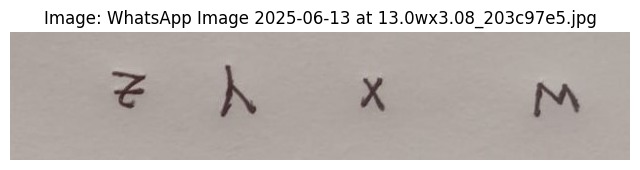

What text is written in WhatsApp Image 2025-06-13 at 13.0wx3.08_203c97e5.jpg? (enter character by character, e.g., 'Hello'): zYXW
Detected 4 characters, you entered 4 characters


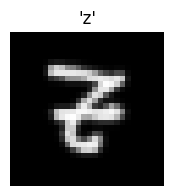

Added 'z' to fine-tuning dataset


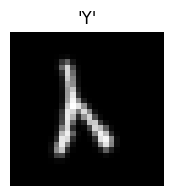

Added 'Y' to fine-tuning dataset


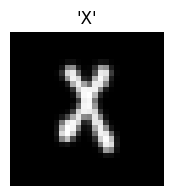

Added 'X' to fine-tuning dataset


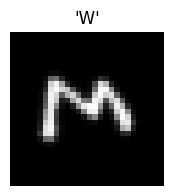

Added 'W' to fine-tuning dataset

--- Processing WhatsApp Image 2025-06-13 at 13.03.08_203c9mn7e5.jpg ---


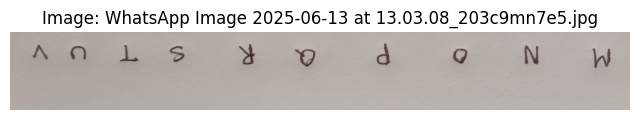

What text is written in WhatsApp Image 2025-06-13 at 13.03.08_203c9mn7e5.jpg? (enter character by character, e.g., 'Hello'): VUTSRQPONM
Detected 10 characters, you entered 10 characters


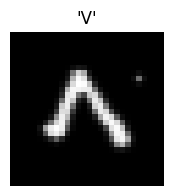

Added 'V' to fine-tuning dataset


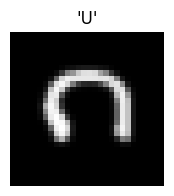

Added 'U' to fine-tuning dataset


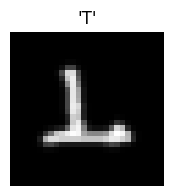

Added 'T' to fine-tuning dataset


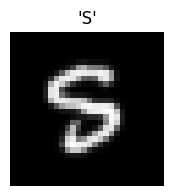

Added 'S' to fine-tuning dataset


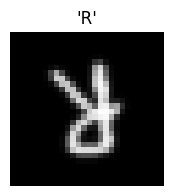

Added 'R' to fine-tuning dataset


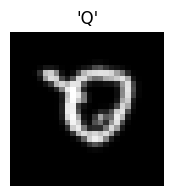

Added 'Q' to fine-tuning dataset


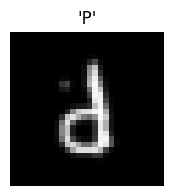

Added 'P' to fine-tuning dataset


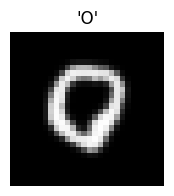

Added 'O' to fine-tuning dataset


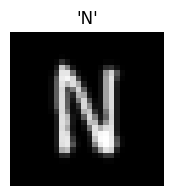

Added 'N' to fine-tuning dataset


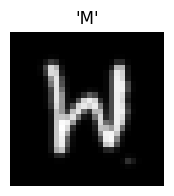

Added 'M' to fine-tuning dataset

✅ Created custom dataset with 14 samples
Characters collected: ['z', 'Y', 'X', 'W', 'V', 'U', 'T', 'S', 'R', 'Q', 'P', 'O', 'N', 'M']

=== FINE-TUNING WITH 14 CUSTOM SAMPLES ===
Augmented dataset: 84 samples
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.4117 - loss: 2.1722 - val_accuracy: 1.0000 - val_loss: 0.3693
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.5194 - loss: 1.6677 - val_accuracy: 1.0000 - val_loss: 0.3668
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5343 - loss: 1.5521 - val_accuracy: 1.0000 - val_loss: 0.3636
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5076 - loss: 1.6301 - val_accuracy: 1.0000 - val_loss: 0.3602
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5229 - loss: 1.5915 - val_accuracy: 1.0000 - val_loss: 0.3566
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5460 - loss: 1.3489 - val_accuracy: 1.0000 - val_loss: 0.3541
Epoch 7/1

✅ Fine-tuned model saved as 'fine_tuned_model.h5'

🎉 Fine-tuning complete!
Now test with a new image to see improved performance.
Upload a test image to see improvement? (y/n): Y
Upload test image:


Saving WhatsApp Image 2025-06-13 at 12.25.16_032e3913.jpg to WhatsApp Image 2025-06-13 at 12.25.16_032e3913.jpg
Testing with fine-tuned model...


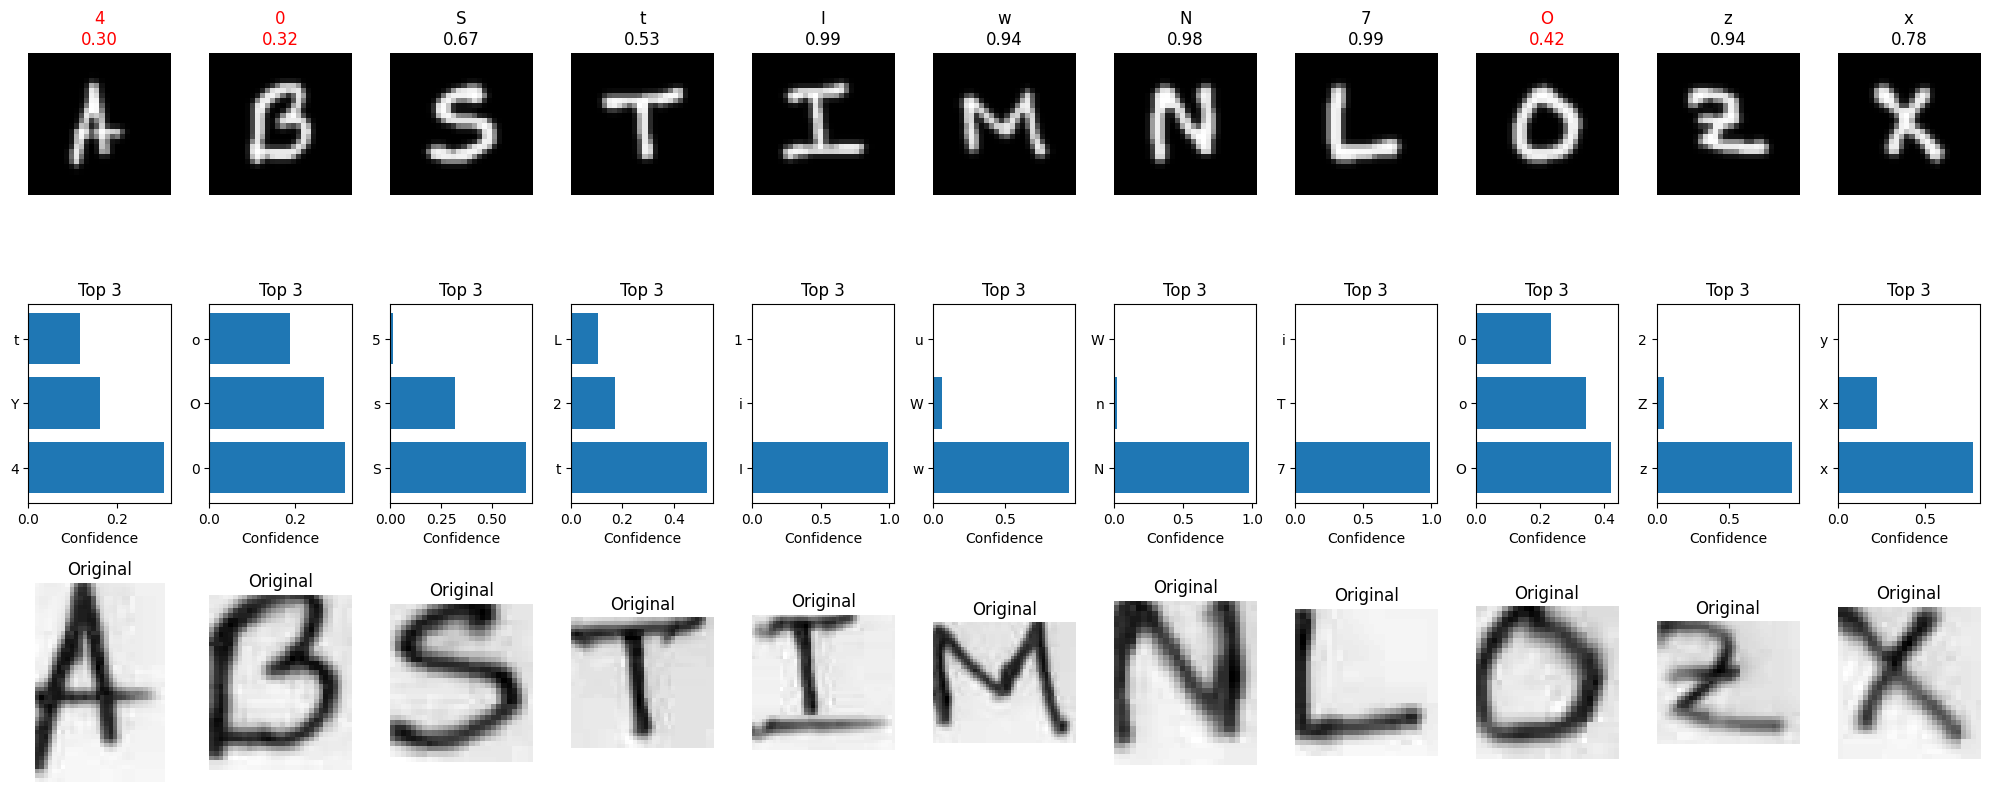

Predicted word: '40StIwN7Ozx'
Average confidence: 0.714

⚠️  LOW CONFIDENCE CHARACTERS (3):
  Position 0: '4' (confidence: 0.30)
    Alternatives: Y(0.16), t(0.12)
  Position 1: '0' (confidence: 0.32)
    Alternatives: O(0.27), o(0.19)
    💡 o/O/0 confusion detected. Check size and thickness.
  Position 8: 'O' (confidence: 0.42)
    Alternatives: o(0.34), 0(0.23)
    💡 o/O/0 confusion detected. Check size and thickness.


In [24]:
# Cell 18: Interactive Fine-tuning Process
def interactive_fine_tuning():
    """Interactive fine-tuning process"""
    print("🎯 INTERACTIVE FINE-TUNING")
    print("This process will:")
    print("1. Let you upload images of your handwriting")
    print("2. You label what characters are written")
    print("3. System fine-tunes the model on your writing style")
    print("4. Test improved performance")

    proceed = input("\nDo you want to proceed with fine-tuning? (y/n): ")

    if proceed.lower() == 'y':
        # Collect custom data
        X_custom, y_custom = create_fine_tuning_dataset()

        if X_custom is not None:
            # Fine-tune model
            fine_tuned_model = fine_tune_model(X_custom, y_custom)

            print("\n🎉 Fine-tuning complete!")
            print("Now test with a new image to see improved performance.")

            # Test with new image
            test_fine_tuned = input("Upload a test image to see improvement? (y/n): ")
            if test_fine_tuned.lower() == 'y':
                print("Upload test image:")
                test_files = files.upload()

                if test_files:
                    test_filename = list(test_files.keys())[0]
                    print("Testing with fine-tuned model...")
                    result = predict_with_confidence_analysis(test_filename, confidence_threshold=0.5)
        else:
            print("No custom data collected. Fine-tuning skipped.")
    else:
        print("Fine-tuning skipped.")

# Run interactive fine-tuning
interactive_fine_tuning()

In [26]:
# Cell 19: Quick Fix for Common Issues
def diagnose_and_fix_issues(image_path):
    """Diagnose common issues and suggest fixes"""
    print("🔍 DIAGNOSING IMAGE ISSUES")

    # Load and analyze image
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Check image properties
    height, width = gray.shape
    print(f"Image size: {width}x{height}")

    # Check brightness
    avg_brightness = np.mean(gray)
    print(f"Average brightness: {avg_brightness:.1f}")

    # Check contrast
    contrast = np.std(gray)
    print(f"Contrast (std): {contrast:.1f}")

    # Issues and fixes
    issues = []
    fixes = []

    if avg_brightness < 100:
        issues.append("Image too dark")
        fixes.append("Increase brightness or use better lighting")

    if avg_brightness > 200:
        issues.append("Image too bright/overexposed")
        fixes.append("Reduce brightness or lighting")

    if contrast < 50:
        issues.append("Low contrast")
        fixes.append("Use darker pen or increase contrast")

    if width < 500 or height < 200:
        issues.append("Image resolution too low")
        fixes.append("Take photo closer or use higher resolution")

    if width > 3000 or height > 3000:
        issues.append("Image too large")
        fixes.append("Resize image or take photo from further away")

    # Check text orientation
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        issues.append("No text detected")
        fixes.append("Check if pen color contrasts with paper")

    # Show results
    if issues:
        print(f"\n⚠️ FOUND {len(issues)} ISSUES:")
        for i, (issue, fix) in enumerate(zip(issues, fixes)):
            print(f"{i+1}. {issue}")
            print(f"   Fix: {fix}")
    else:
        print("✅ No obvious issues detected")

    # Show processed versions
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    axes[0,0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0,0].set_title('Original')
    axes[0,0].axis('off')

    axes[0,1].imshow(gray, cmap='gray')
    axes[0,1].set_title('Grayscale')
    axes[0,1].axis('off')

    axes[0,2].imshow(binary, cmap='gray')
    axes[0,2].set_title('Binary')
    axes[0,2].axis('off')

    # Apply fixes
    enhanced = cv2.equalizeHist(gray) if contrast < 50 else gray
    axes[1,0].imshow(enhanced, cmap='gray')
    axes[1,0].set_title('Enhanced')
    axes[1,0].axis('off')

    # Brightness adjusted
    bright_adj = cv2.convertScaleAbs(gray, alpha=1.2, beta=30) if avg_brightness < 100 else gray
    axes[1,1].imshow(bright_adj, cmap='gray')
    axes[1,1].set_title('Brightness Adjusted')
    axes[1,1].axis('off')

    # Final processed
    final = advanced_preprocess_image(image_path)
    axes[1,2].imshow(final, cmap='gray')
    axes[1,2].set_title('Final Processed')
    axes[1,2].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
# Cell 20: Complete Testing Suite
print("""
🚀 COMPLETE TESTING SUITE READY!

Available Functions:
1. Upload image → Automatic multi-method testing
2. interactive_fine_tuning() → Customize model for your handwriting
3. diagnose_and_fix_issues('image.jpg') → Debug image problems
4. analyze_confusing_pairs() → Check model performance on tricky characters

Tips for Best Results:
📸 Photo: Good lighting, straight angle, steady hand
✏️ Writing: Dark pen, white paper, clear spacing
🎯 Size: Characters at least 1cm tall
💡 Issues: Use diagnose_and_fix_issues() if recognition fails """)


🚀 COMPLETE TESTING SUITE READY!

Available Functions:
1. Upload image → Automatic multi-method testing
2. interactive_fine_tuning() → Customize model for your handwriting
3. diagnose_and_fix_issues('image.jpg') → Debug image problems
4. analyze_confusing_pairs() → Check model performance on tricky characters

Tips for Best Results:
📸 Photo: Good lighting, straight angle, steady hand
✏️ Writing: Dark pen, white paper, clear spacing
🎯 Size: Characters at least 1cm tall
💡 Issues: Use diagnose_and_fix_issues() if recognition fails 
